In [1]:
import os
import numpy as np
import pandas as pd
import torch
import os.path as osp
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'
MASK_DIR = '/mnt/chicm/data/open-images/masks/train'

In [12]:
!ls /mnt/chicm/open-images-seg/work_dirs/parent_cascade_mask_rcnn_x101_64x4d_fpn_1x/*.pkl -lh

-rw-rw-r-- 1 core core  34M Sep  2 17:31 /mnt/chicm/open-images-seg/work_dirs/parent_cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0902_1000.pkl
-rw-rw-r-- 1 core core 3.0G Sep  3 04:44 /mnt/chicm/open-images-seg/work_dirs/parent_cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0903_1.pkl


In [3]:
df_des = pd.read_csv('challenge-2019-classes-description-segmentable.csv', names=['class', 'name'])
class_dict = df_des.set_index('class').to_dict()['name']

In [4]:
df_test = pd.read_csv('sample_empty_submission.csv')
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,-1,-1,NaN
1,52a76f3fe21185bf,-1,-1,NaN
2,65e9da7c04c8e4cd,-1,-1,NaN
3,6d10fa21d93bd6cc,-1,-1,NaN
4,0841dee573a875ca,-1,-1,NaN


In [5]:
def get_top_classes(start_index, end_index):
    df = pd.read_csv('top_classes_parent.csv')
    c = df['class'].values[start_index:end_index]
    #print(df.head())
    stoi = { c[i]: i for i in range(len(c)) }
    return c, stoi

In [6]:
classes, stoi = get_top_classes(0, 26)

In [7]:
classes[:5]

array(['/m/0k4j', '/m/01g317', '/m/0c9ph5', '/m/0138tl', '/m/06msq'],
      dtype=object)

In [10]:
with open('/mnt/chicm/open-images-seg/work_dirs/parent_cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0903_1.pkl', 'rb') as f:
    preds = pickle.load(f)

In [11]:
len(preds)

99999

In [13]:
len(preds[0][0])

26

In [65]:
preds[0][0]

[array([], shape=(0, 5), dtype=float32),
 array([[2.6640338e+02, 1.8149496e+02, 7.3771661e+02, 5.3601978e+02,
         2.4876124e-03],
        [3.9398590e+02, 4.4525348e+02, 4.4294409e+02, 5.0714835e+02,
         1.1788722e-03]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.6709518e+02, 1.8158765e+02, 7.3808252e+02, 5.3470410e+02,
         1.3927587e-03]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[3.9841064e+02, 4.4428574e+02, 7.1684027e+02, 5.5981598e+02,


In [14]:
import pycocotools.mask as mutils

In [16]:
mask1 = mutils.decode(preds[0][1][1][0])

In [17]:
mask1.shape

(683, 1024)

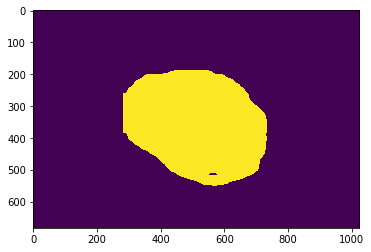

In [19]:
plt.imshow(mutils.decode(preds[0][1][1][0]))

In [20]:
# all root '/m/0bl9f'

with open('challenge-2019-label300-segmentable-hierarchy.json', 'r') as f:
    h = json.load(f)

leaf_classes = []
parent_classes = []
parent_dict = {}

def travel(root, parent=[]):
    if 'Subcategory' in root:
        parent_classes.append(root['LabelName'])
        for c in root['Subcategory']:
            travel(c, parent+[root['LabelName']])
    else:
        leaf_classes.append(root['LabelName'])
        parent_dict[root['LabelName']] = parent

travel(h)

In [21]:
parent_dict['/m/029b3']

['/m/0bl9f', '/m/0138tl']

In [22]:
def get_mask(idx):
    box_pred, mask_pred = preds[idx]
    masks, labels, confs = [], [], []
    for i in range(len(classes)):
        for encoded_mask, bbox in zip(mask_pred[i], box_pred[i]):
            if True: #bbox[4] > 0.01:
                mask = mutils.decode(encoded_mask)
                masks.append(mask)
                labels.append(classes[i])
                confs.append(bbox[4])
                
                # add parent
                #for parent_class in parent_dict[classes[i]]:
                #    if parent_class != '/m/0bl9f':
                #        masks.append(mask)
                #        labels.append(classes[i])
                #        confs.append(bbox[4])
                
    return masks, labels, confs

In [23]:
def show_pred(idx):
    row = df_test.iloc[idx]
    fn = TEST_IMG_DIR + '/' + row.ImageID + '.jpg'
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    masks, labels, confs = get_mask(idx)
    
    columns = 4
    plt.figure(figsize=(20, 15))
    
    plt.subplot(len(masks) / columns + 1, columns, 1)
    plt.imshow(img)
    plt.title(str(img.shape))
    
    for i, mask in enumerate(masks):
        plt.subplot(len(masks) / columns + 1, columns, i+2)
        if labels is not None:
            plt.title(class_dict[labels[i]] + str(mask.shape)+','+str(confs[i]))
        plt.imshow(mask)

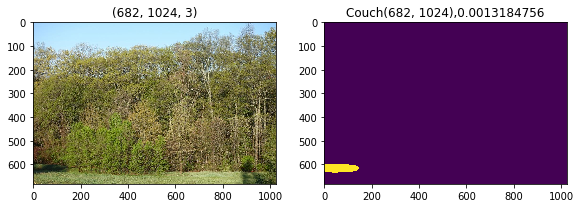

In [24]:
show_pred(2)

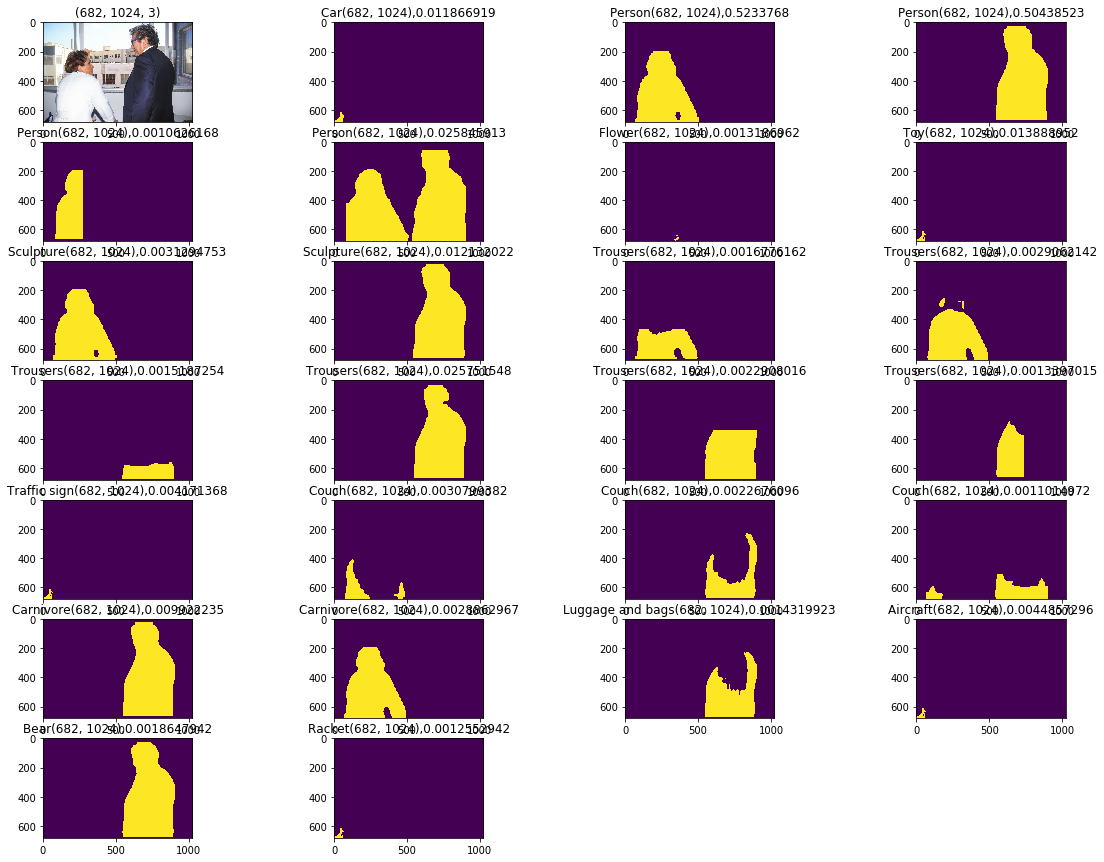

In [25]:
show_pred(3)

In [26]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


# create submission

In [27]:
def get_fn(img_id):
    return TEST_IMG_DIR + '/' + img_id + '.jpg'

In [28]:
df_test.ImageWidth = df_test.ImageID.map(lambda x: get_image_size(get_fn(x))[0])

In [29]:
df_test.ImageHeight = df_test.ImageID.map(lambda x: get_image_size(get_fn(x))[1])

In [30]:
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,NaN
1,52a76f3fe21185bf,1024,683,NaN
2,65e9da7c04c8e4cd,1024,682,NaN
3,6d10fa21d93bd6cc,1024,682,NaN
4,0841dee573a875ca,1024,683,NaN


In [31]:
df_test['img_index'] = df_test.index
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString,img_index
0,80155d58d0ee19bd,1024,683,NaN,0
1,52a76f3fe21185bf,1024,683,NaN,1
2,65e9da7c04c8e4cd,1024,682,NaN,2
3,6d10fa21d93bd6cc,1024,682,NaN,3
4,0841dee573a875ca,1024,683,NaN,4


In [32]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)
    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')
    

In [33]:
encode_binary_mask(mask1>0)

'eNptU8lywyAM/SUwToKZHoszaWxjO0uXaafTQ7o4Xv7/VoEEDhOHgYeEJOTw3s/luurF5xeLf7xKYIgiLdN9ul8XaSEK4XyJYSapuAlYkt+jG9zQhEo2lrudRZi0MldjroTx5EVk3E0ecryNJ7crTcqaR2wlZUJ3hTPbGe3x1J3TbRbZ3Dl1z0Me/lc86sPXTRZ6DTvD777gLoayl2KWkC1UjDqKazOzWMMbNx7eV6Me8la1WZ0PeQ3Y5GM+ZYi1asA/BWxUnU263lqc7QbsUU66DdiqQY76sD2oXg76GPCorrLXp4An1cmrPt/hWf3JTj8DdvIX8AVsxE5+A76BjdjJC9R5V0MWfWd4g6U38a/K/Yuj7Tk983TONJ7Vjsmer+gNPPHMCRHEMI6aI54J1FMZK8auAhS5Aj3aGH7LSFInn1Xo9qg+7BrqVWK/flrtNo8PoG3h7hCo3NLWcyoHT1rALTA2u+y16j7M0Vzqw/ofNoUIMg=='

In [34]:
def get_pred_str(idx):
    masks, labels, confs = get_mask(idx)
    res = []
    for mask, label, conf in zip(masks, labels, confs):
        res.append(label)
        res.append('{:.7f}'.format(conf))
        res.append(encode_binary_mask(mask.astype(np.bool)))
    
    return ' '.join(res)

In [35]:
def set_pred_str(df):
    df['PredictionString'] = df.img_index.map(lambda x: get_pred_str(x))
    return df

In [36]:
from multiprocessing import Pool

def parallel_apply(df, func, n_cores=24):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


In [37]:
df_test = parallel_apply(df_test, set_pred_str)

In [38]:
df_test.shape

(99999, 5)

In [39]:
df_test = df_test.drop(columns=['img_index'], axis=1)
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,/m/0k4j 0.2084172 eNqNU1tuwyAQvBLLw6gnSI15KAeo...
1,52a76f3fe21185bf,1024,683,/m/0k4j 0.0547043 eNpLCQmxzDeISTFAAEN/GIlgGWDI...
2,65e9da7c04c8e4cd,1024,682,/m/02crq1 0.0013185 eNoLiDDMN4hOMYAAQ38Df0MQCW...
3,6d10fa21d93bd6cc,1024,682,/m/0k4j 0.0118669 eNpNi8EKwkAMRH9pdtFFoQfFi1TJ...
4,0841dee573a875ca,1024,683,/m/0k4j 0.0986574 eNoLC4wxSjDKTjJABYb+MBIZg0gE...


In [40]:
df_test.tail()

,ImageID,ImageWidth,ImageHeight,PredictionString
99994,e40f388b3a4f80a6,1024,576,/m/01g317 0.0212333 eNrNT2trhDAQ/EsxLxMfd63VmJ...
99995,a21b4cd415d83b4d,1024,767,/m/0k4j 0.0278251 eNpdjM0Kg0AMhF9psumP7L20VM0U...
99996,750b5d6e41c23bc9,961,768,/m/0k4j 0.0107757 eNp9lHtv4joQxb+SH6Hs6q50K63U...
99997,4944489aca12f92e,1024,678,/m/0k4j 0.0137566 eNo9jVtTwkAMhf9StooODk4CjtLL...
99998,632dad5b912b4b6a,1022,768,/m/0k4j 0.0033885 eNpNyjEOgzAMBdArfScQiYGxEmoT...


In [41]:
df_test.to_csv('sub_parent_0903_1_top50.csv', index=False)

In [42]:
!kaggle competitions submit -c open-images-2019-instance-segmentation -f sub_parent_0903_1_top50.csv -m "0903 parent submit"

100%|██████████████████████████████████████| 1.60G/1.60G [01:07<00:00, 25.5MB/s]
Successfully submitted to Open Images 2019 - Instance Segmentation

In [91]:
!ls -lh

total 23G
-rw-rw-r-- 1 core core 5.3K Aug  8 17:40 challenge-2019-classes-description-segmentable.csv
-rw-rw-r-- 1 core core  21K Jul 26 08:26 challenge-2019-label300-segmentable-hierarchy.json
-rw-rw-r-- 1 core core 369M Aug  8 17:46 challenge-2019-train-segmentation-bbox.csv
-rw-rw-r-- 1 core core  82M Aug  8 17:47 challenge-2019-train-segmentation-labels.csv
-rw-rw-r-- 1 core core 613M Aug  8 18:03 challenge-2019-train-segmentation-masks.csv
-rw-rw-r-- 1 core core 6.4M Aug  8 18:03 challenge-2019-validation-segmentation-bbox.csv
-rw-rw-r-- 1 core core 2.4M Aug  8 18:03 challenge-2019-validation-segmentation-labels.csv
-rw-rw-r-- 1 core core 2.7M Aug  8 18:03 challenge-2019-validation-segmentation-masks.csv
-rw-rw-r-- 1 core core 543K Sep  1 19:05 check_preds.ipynb
-rw-r--r-- 1 core core 369K Sep  1 15:23 eda.ipynb
-rw-rw-r-- 1 core core 9.7G Jul 26 08:32 open-images-2019-instance-segmentation.zip
-rw-rw-r-- 1 core core 2.3M Sep  1 00:03 sample_empty_submission-Copy1.csv
-rw-rw---- 1